In [4]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt

In [5]:
#gym.envs.registry.all()
# env = gym.make('CartPole-v0')
env = gym.make('FrozenLake-v0')

INFO:gym.envs.registration:Making new env: FrozenLake-v0
[2017-07-12 23:04:57,813] Making new env: FrozenLake-v0


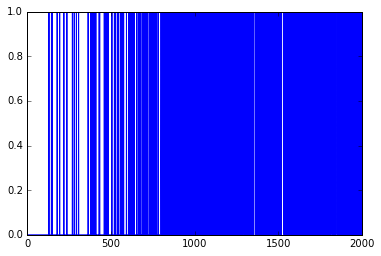

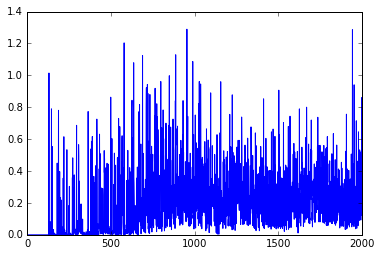

In [17]:
lr = 0.1
e = 0.1
hidden_size = 4
discount_rate = 0.99
epoch = 2000
num_actions = env.action_space.n
num_states = env.observation_space.n

tf.reset_default_graph()

# state
target_q_value = tf.placeholder(dtype=tf.float32,shape=[None,num_actions])
s = tf.placeholder(dtype=tf.float32,shape=[None,num_states])
w1 = tf.Variable(tf.random_uniform([16,4],0,0.01))
# b1 = tf.Variable(tf.zeros((1,hidden_size)))
# w2 = tf.Variable(tf.random_normal((hidden_size,num_actions)))
# b2 = tf.Variable(tf.zeros((1,num_actions)))

q_value = tf.matmul(s,w1)
out = tf.nn.softmax(tf.nn.sigmoid(q_value))
greedy_action = tf.argmax(out,axis=1)

cost = tf.reduce_sum(tf.square(q_value - target_q_value))
grad = tf.train.GradientDescentOptimizer(lr).minimize(cost)

init= tf.global_variables_initializer()
with tf.Session() as sess:
    sum_rewards_list = []
    costs = []
    sess.run(init)
    for i in range(epoch):
        s1 = env.reset()
        done = False
        sum_rewards = 0
        sum_cost = 0
        while not done:
            # choose a greedy action, get current state's q-value
            a,q1 = sess.run([greedy_action,q_value],{s:np.identity(16)[s1:s1+1]})

            # e~greedy
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            s2,r,done,_ = env.step(a[0])

            # get next state's q-value
            q2 = sess.run(q_value,{s:np.identity(16)[s2:s2+1]})

            maxQ2 = np.max(q2) # off-policy
            target = q1
            target[0,a[0]] = r + discount_rate*maxQ2

            c,_ = sess.run([cost,grad],{s:np.identity(16)[s1:s1+1],target_q_value:target})
            sum_rewards += r
            sum_cost += c
            s1 = s2
            e = 1./((i/50) + 10)
        sum_rewards_list.append(sum_rewards)
        costs.append(sum_cost)
    plt.plot(sum_rewards_list)
    plt.show()
    plt.plot(costs)
    plt.show()